First, let's import all the necessary dependencies.

In [1]:
import datetime
import display
import matplotlib.pyplot as plt
import xarray as xr

Let's define some configuration variables.

In [2]:
DATASET_LOCATION = "s3://ecmwf-era5-land/reanalysis-era5-land-no-antartica-v0.zarr"

REFERENCE_PERIOD = slice("1991", "2020")
EVENTS = {
    "italy-2023-05": {
        "area": {"latitude": slice(48, 34), "longitude": slice(5, 20)},
        "location": {"latitude": 44.2, "longitude": 11.9, "method": "nearest"},
        "time": ["2023-05-17", "2023-05-18"],
        "vmax": 150,
    },
    "greece-2023-09": {
        "area": {"latitude": slice(41, 34), "longitude": slice(19, 28)},
        "location": {"latitude": 39.25, "longitude": 21.9, "method": "nearest"},
        "time": ["2023-09-06", "2023-09-07"],
        "vmax": 400,
    },
    "pakistan-2022-06": {
        "area": {"latitude": slice(38, 23), "longitude": slice(60, 78)},
        "location": {"latitude": 29, "longitude": 67, "method": "nearest"},
        "time": ["2022-08-23", "2022-08-24", "2022-08-25", "2022-08-26", "2022-08-27", "2022-08-28", "2022-08-29", "2022-08-30"],
        "vmax": 300,
    },
}

SELECTED_EVENT = "greece-2023-09"

AREA = EVENTS[SELECTED_EVENT]["area"]
LOCATION = EVENTS[SELECTED_EVENT]["location"]
TIME = EVENTS[SELECTED_EVENT]["time"]
YEAR, MONTH = EVENTS[SELECTED_EVENT]["time"][0].split("-")[:2]
VMAX = EVENTS[SELECTED_EVENT]["vmax"]

In [3]:
# activate dask distributed
#
# import distributed
# client = distributed.Client("tcp://dask-scheduler:8786")
# client

In the following lines we:

- establish a connection with the remote dataset
- show its metadata

It is worth noticing that, in the first operation, only the information necessary to gather the dataset's metadata (e.g. its sizes, dimensions, variables' type and attributes) is actually downloaded from its remote location to the local machine.

In [4]:
ds = xr.open_dataset(DATASET_LOCATION, chunks={}, engine="zarr").astype("float32")
ds

<xarray.Dataset>
Dimensions:     (valid_time: 647208, latitude: 1472, longitude: 3600)
Coordinates:
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -56.9 -57.0 -57.1
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1950-01-01 ... 2023-10-31T23:00:00
Data variables:
    ssr         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-11-18T20:02 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Here we want to compute the total precipitation observed over during Storm Daniel, i.e. from 6 to 7 September 2023.

Note that the operations prescribed in the following lines are actually performed, and the resulting data downloaded, only when the `.compute()` method is met. For this reason, as a general rule to maximize efficiency, the compute() method should be placed after an operation which significantly reduce the amount of data, such as after selection and reduction operations.

In [5]:
tp = ds.tp
tp_days_area = tp.sel(valid_time=TIME, **AREA)
tp_days_sum = tp_days_area.sum("valid_time")
tp_days_sum

<xarray.DataArray 'tp' (latitude: 70, longitude: 90)>
dask.array<sum-aggregate, shape=(70, 90), dtype=float32, chunksize=(49, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 40.9 40.8 40.7 40.6 ... 34.3 34.2 34.1 34.0
  * longitude  (longitude) float64 19.0 19.1 19.2 19.3 ... 27.6 27.7 27.8 27.9
    number     int64 ...
    surface    float64 ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 647208
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

In [6]:
%%time

tp_days_sum = tp_days_sum.compute()
tp_days_sum_mm = tp_days_sum * 1000
tp_days_sum_mm.attrs["units"] = "mm"

CPU times: user 921 ms, sys: 403 ms, total: 1.32 s
Wall time: 815 ms


Let's plot the results on a map.

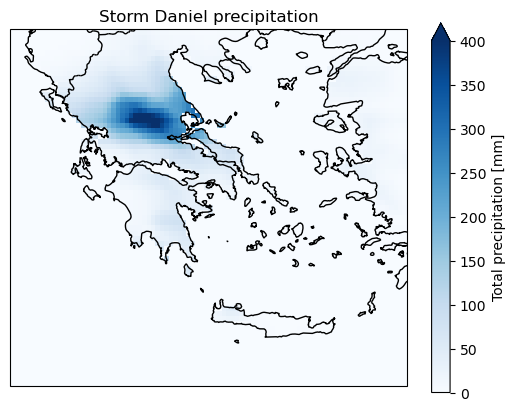

In [7]:
display.map(tp_days_sum_mm, vmax=VMAX, title="Storm Daniel precipitation")

Now, we want to compare the total precipitation observed during Storm Daniel with the average precipitation observed in the whole month of September between 1991 and 2020. 

The same considerations done before apply here.

In [8]:
YEARS = [
    "1991", "1992", "1993",
    "1994", "1995", "1996",
    "1997", "1998", "1999",
    "2000", "2001", "2002",
    "2003", "2004", "2005",
    "2006", "2007", "2008",
    "2009", "2010", "2011",
    "2012", "2013", "2014",
    "2015", "2016", "2017",
    "2018", "2019", "2020",
]
DAYS = [
    "01", "02", "03",
    "04", "05", "06",
    "07", "08", "09",
    "10", "11", "12",
    "13", "14", "15",
    "16", "17", "18",
    "19", "20", "21",
    "22", "23", "24",
    "25", "26", "27",
    "28", "29", "30",
]

MONTH_REFERENCE_TIME = [f"{y}-{MONTH}-{d}" for y in YEARS for d in DAYS]

tp = ds.tp
tp_ref_area = tp.sel(valid_time=MONTH_REFERENCE_TIME, **AREA)
tp_ref_month_sum = (tp_ref_area.sum("valid_time") / len(YEARS))

In [9]:
%%time

tp_ref_month_sum = tp_ref_month_sum.compute()
tp_ref_month_sum_mm = tp_ref_month_sum * 1000
tp_ref_month_sum_mm.attrs["units"] = "mm"

CPU times: user 24.2 s, sys: 6.36 s, total: 30.6 s
Wall time: 9.73 s


Let's plot the results on two different maps.

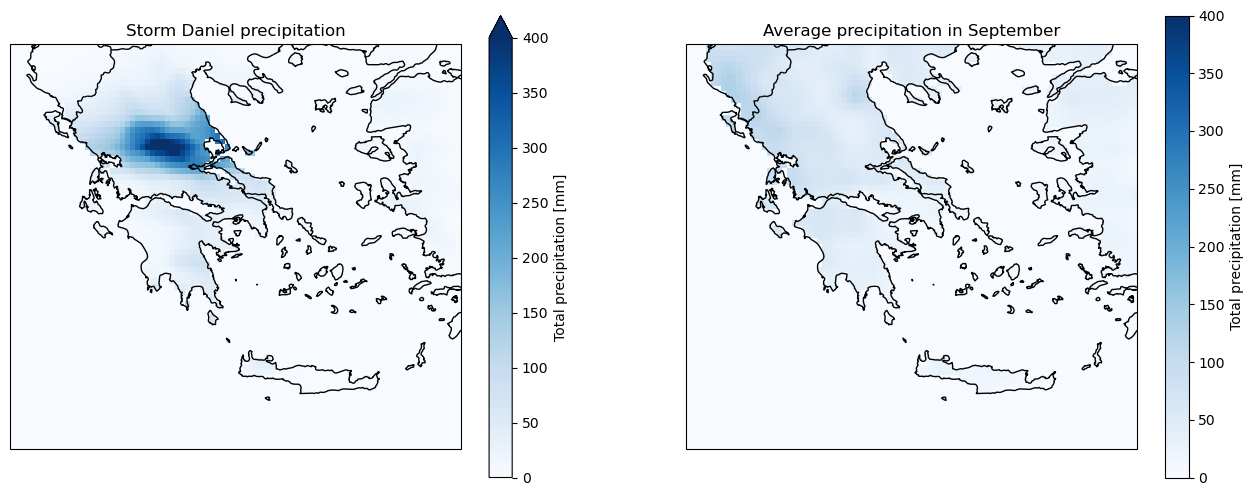

In [10]:
display.maps(
    [tp_days_sum_mm, tp_ref_month_sum_mm],
    vmax=VMAX,
    axs_set=[
        {"title": "Storm Daniel precipitation"},
        {"title": "Average precipitation in September"},
    ],
)

Finally, we want to compare the evolution of total cumulated precipitation over 2023 on a specific location in Greece hinterland hit by Storm Daniel, with the evolution of total cumulated precipitation over all years between 1991 and 2020 on the same location.

The same considerations done before apply here.

In [11]:
tp = ds.tp
tp_location = ds.tp.sel(**LOCATION)
tp_location

<xarray.DataArray 'tp' (valid_time: 647208)>
dask.array<getitem, shape=(647208,), dtype=float32, chunksize=(2880,), chunktype=numpy.ndarray>
Coordinates:
    latitude    float64 39.2
    longitude   float64 21.9
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1950-01-01 ... 2023-10-31T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  3600
    GRIB_Ny:                                  1472
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tp
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    last_restart_dim_updated:                 647208
    long_name:                                Total precipitation
    standard_name:                            unknown
    units:                                    m

In [12]:
%%time

tp_location = tp_location.compute()
tp_location_year = tp_location.sel(valid_time=YEAR).groupby("valid_time.time")[datetime.time()]
tp_location_reference = tp_location.sel(valid_time=REFERENCE_PERIOD).groupby("valid_time.time")[datetime.time()]

CPU times: user 31.2 s, sys: 8.56 s, total: 39.7 s
Wall time: 18.6 s


Let's plot the results.

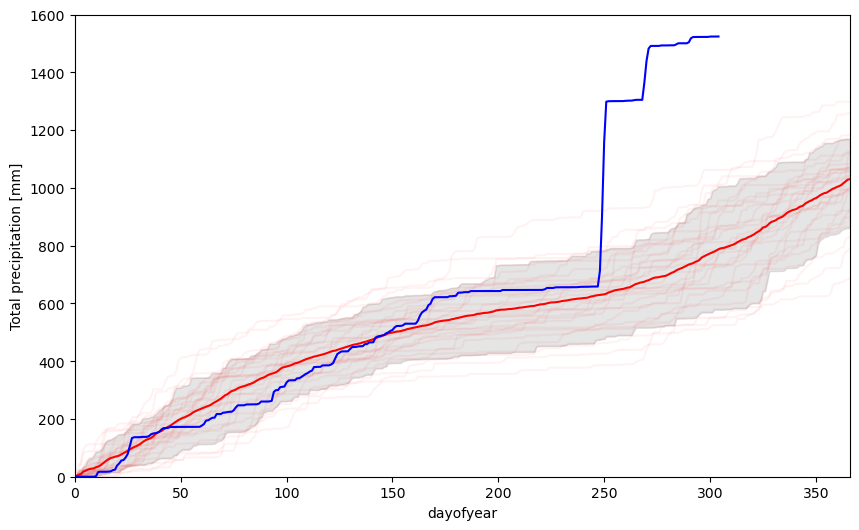

In [13]:
display.compare(tp_location_year, tp_location_reference, time="valid_time", ylim=[0, 1600])